# Assignment 11
## 11.0 Introduction
In this assignement, we will try to have an overlook on OpenPose algorithm (https://arxiv.org/pdf/1812.08008.pdf). Instinctively, we could try to recognize human pose by making a network who perform a segmentation on each articulation of human body. Then we would just need to link all the joints toghether to make a digital skeleton, not that simple of course. If their is several persons on the same image for instance, how to link the good neck with the good head???
The idea behind this algorithm is to have to differents maps: a Part Affinity Fields (PAFs) and Part Confidence Maps(PCMs)

In [62]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://www.researchgate.net/publication/332669619/figure/fig5/AS:751775762092034@1556248717717/Part-Affinity-Fields-Architecture-Figure-1.ppm")

The network structure is above, branch 1 and 2 are respectively in charge of generating PCM and PAF thru multiple stage to have more accuracy.

In [63]:
Image(url= "https://news.mynavi.jp/article/cv_future-47/index_images/index.jpg")

The first network generating the PCM find each part of the body (elbow, neck, etc... colored points above) and the network generating the PAF is linking the part together (orange field above). Then we apply a greedy/hongarian algorithm to link the part which are most probably join.

## 11.1 Setup the network and modify it.

We will use a pretrain network to do all our work. All the code is in the folder "openpose". You should first of all download the weights of the network, their is two file : "body_pose_model.pth" (199.57Mb) et "hand_pose_model.pth" (140.52Mb) (https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=0) and place them into a "model" folder you create. Then the few line beneath should run perfectly.

We want you to get into the code of the network in the folder "openpose/body" and you should modify it to be able to access the PCM and PAF. Remember, like for the segmentation their is as many layer as their is labels. Then you should be able to overlay the original image with one of the map (only one layer of each map)

In [16]:
import sys
sys.path.insert(0, 'openpose')
import cv2
import model
import util
from hand import Hand
# from body import Body
import matplotlib.pyplot as plt
import copy
import numpy as np
import torch
import glob
import os

PARTS = {
    "nose":0,
    "neck":1,
    "right_shldr":2,
    "right_elbw":3,
    "right_wrst":4,
    "left_shldr":5,
    "left_elbw":6,
    "left_wrst":7,
    "right_hps":8,
    "right_kn":9,
    "right_nkl":10,
    "left_hps":11,
    "left_kn":12,
    "left_nkl":13,
    "right_eye":14,
    "left_eye":15,
    "right_hear":16,
    "left_hear":17,
}
N = len(PARTS)

In [27]:
import cv2
import numpy as np
import util
import math
import time
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib
from model import bodypose_model
import torch
from torchvision import transforms

class Body(object):
    def __init__(self, model_path):
        self.model = bodypose_model()
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        model_dict = util.transfer(self.model, torch.load(model_path))
        self.model.load_state_dict(model_dict)
        self.model.eval()

    def __call__(self, oriImg):
        # scale_search = [0.5, 1.0, 1.5, 2.0]
        scale_search = [0.5]
        boxsize = 368
        stride = 8
        padValue = 128
        thre1 = 0.1
        thre2 = 0.05
        multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
        heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
        # 38 == number of pairs
        paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

        for m in range(len(multiplier)):
            scale = multiplier[m]
            imageToTest = cv2.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
            im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
            im = np.ascontiguousarray(im)

            data = torch.from_numpy(im).float()
            if torch.cuda.is_available():
                data = data.cuda()
            # data = data.permute([2, 0, 1]).unsqueeze(0).float()
            with torch.no_grad():
                Mconv7_stage6_L1, Mconv7_stage6_L2 = self.model(data)
            Mconv7_stage6_L1 = Mconv7_stage6_L1.cpu().numpy()
            Mconv7_stage6_L2 = Mconv7_stage6_L2.cpu().numpy()

            # extract outputs, resize, and remove padding
            # heatmap = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[1]].data), (1, 2, 0))  # output 1 is heatmaps
            heatmap = np.transpose(np.squeeze(Mconv7_stage6_L2), (1, 2, 0))  # output 1 is heatmaps
            heatmap = cv2.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
            heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
            heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
            

            # paf = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[0]].data), (1, 2, 0))  # output 0 is PAFs
            paf = np.transpose(np.squeeze(Mconv7_stage6_L1), (1, 2, 0))  # output 0 is PAFs
            paf = cv2.resize(paf, (0, 0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
            paf = paf[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
            paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

            heatmap_avg += heatmap_avg + heatmap / len(multiplier)
            paf_avg += + paf / len(multiplier)

        all_peaks = []
        peak_counter = 0

        for part in range(18):
            map_ori = heatmap_avg[:, :, part]
            one_heatmap = gaussian_filter(map_ori, sigma=3)

            map_left = np.zeros(one_heatmap.shape)
            map_left[1:, :] = one_heatmap[:-1, :]
            map_right = np.zeros(one_heatmap.shape)
            map_right[:-1, :] = one_heatmap[1:, :]
            map_up = np.zeros(one_heatmap.shape)
            map_up[:, 1:] = one_heatmap[:, :-1]
            map_down = np.zeros(one_heatmap.shape)
            map_down[:, :-1] = one_heatmap[:, 1:]

            peaks_binary = np.logical_and.reduce(
                (one_heatmap >= map_left, one_heatmap >= map_right, one_heatmap >= map_up, one_heatmap >= map_down, one_heatmap > thre1))
            peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
            peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
            peak_id = range(peak_counter, peak_counter + len(peaks))
            peaks_with_score_and_id = [peaks_with_score[i] + (peak_id[i],) for i in range(len(peak_id))]

            all_peaks.append(peaks_with_score_and_id)
            peak_counter += len(peaks)

        # find connection in the specified sequence, center 29 is in the position 15
        limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
                   [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
                   [1, 16], [16, 18], [3, 17], [6, 18]]
        # the middle joints heatmap correpondence
        mapIdx = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22], \
                  [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52], \
                  [55, 56], [37, 38], [45, 46]]

        connection_all = []
        special_k = []
        mid_num = 10

        for k in range(len(mapIdx)):
            score_mid = paf_avg[:, :, [x - 19 for x in mapIdx[k]]]
            candA = all_peaks[limbSeq[k][0] - 1]
            candB = all_peaks[limbSeq[k][1] - 1]
            nA = len(candA)
            nB = len(candB)
            indexA, indexB = limbSeq[k]
            if (nA != 0 and nB != 0):
                connection_candidate = []
                for i in range(nA):
                    for j in range(nB):
                        vec = np.subtract(candB[j][:2], candA[i][:2])
                        norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                        vec = np.divide(vec, norm)

                        startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                                            np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                        vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                          for I in range(len(startend))])
                        vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                          for I in range(len(startend))])

                        score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                        score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(
                            0.5 * oriImg.shape[0] / norm - 1, 0)
                        criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                        criterion2 = score_with_dist_prior > 0
                        if criterion1 and criterion2:
                            connection_candidate.append(
                                [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

                connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
                connection = np.zeros((0, 5))
                for c in range(len(connection_candidate)):
                    i, j, s = connection_candidate[c][0:3]
                    if (i not in connection[:, 3] and j not in connection[:, 4]):
                        connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                        if (len(connection) >= min(nA, nB)):
                            break

                connection_all.append(connection)
            else:
                special_k.append(k)
                connection_all.append([])

        # last number in each row is the total parts number of that person
        # the second last number in each row is the score of the overall configuration
        subset = -1 * np.ones((0, 20))
        candidate = np.array([item for sublist in all_peaks for item in sublist])

        for k in range(len(mapIdx)):
            if k not in special_k:
                partAs = connection_all[k][:, 0]
                partBs = connection_all[k][:, 1]
                indexA, indexB = np.array(limbSeq[k]) - 1

                for i in range(len(connection_all[k])):  # = 1:size(temp,1)
                    found = 0
                    subset_idx = [-1, -1]
                    for j in range(len(subset)):  # 1:size(subset,1):
                        if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                            subset_idx[found] = j
                            found += 1

                    if found == 1:
                        j = subset_idx[0]
                        if subset[j][indexB] != partBs[i]:
                            subset[j][indexB] = partBs[i]
                            subset[j][-1] += 1
                            subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
                    elif found == 2:  # if found 2 and disjoint, merge them
                        j1, j2 = subset_idx
                        membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                        if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                            subset[j1][:-2] += (subset[j2][:-2] + 1)
                            subset[j1][-2:] += subset[j2][-2:]
                            subset[j1][-2] += connection_all[k][i][2]
                            subset = np.delete(subset, j2, 0)
                        else:  # as like found == 1
                            subset[j1][indexB] = partBs[i]
                            subset[j1][-1] += 1
                            subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

                    # if find no partA in the subset, create a new subset
                    elif not found and k < 17:
                        row = -1 * np.ones(20)
                        row[indexA] = partAs[i]
                        row[indexB] = partBs[i]
                        row[-1] = 2
                        row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + connection_all[k][i][2]
                        subset = np.vstack([subset, row])
        # delete some rows of subset which has few parts occur
        deleteIdx = []
        for i in range(len(subset)):
            if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
                deleteIdx.append(i)
        subset = np.delete(subset, deleteIdx, axis=0)

        # subset: n*20 array, 0-17 is the index in candidate, 18 is the total score, 19 is the total parts
        # candidate: x, y, score, id
        return candidate, subset, heatmap_avg, paf_avg

In [28]:
body_estimation = Body('model/body_pose_model.pth')
hand_estimation = Hand('model/hand_pose_model.pth')

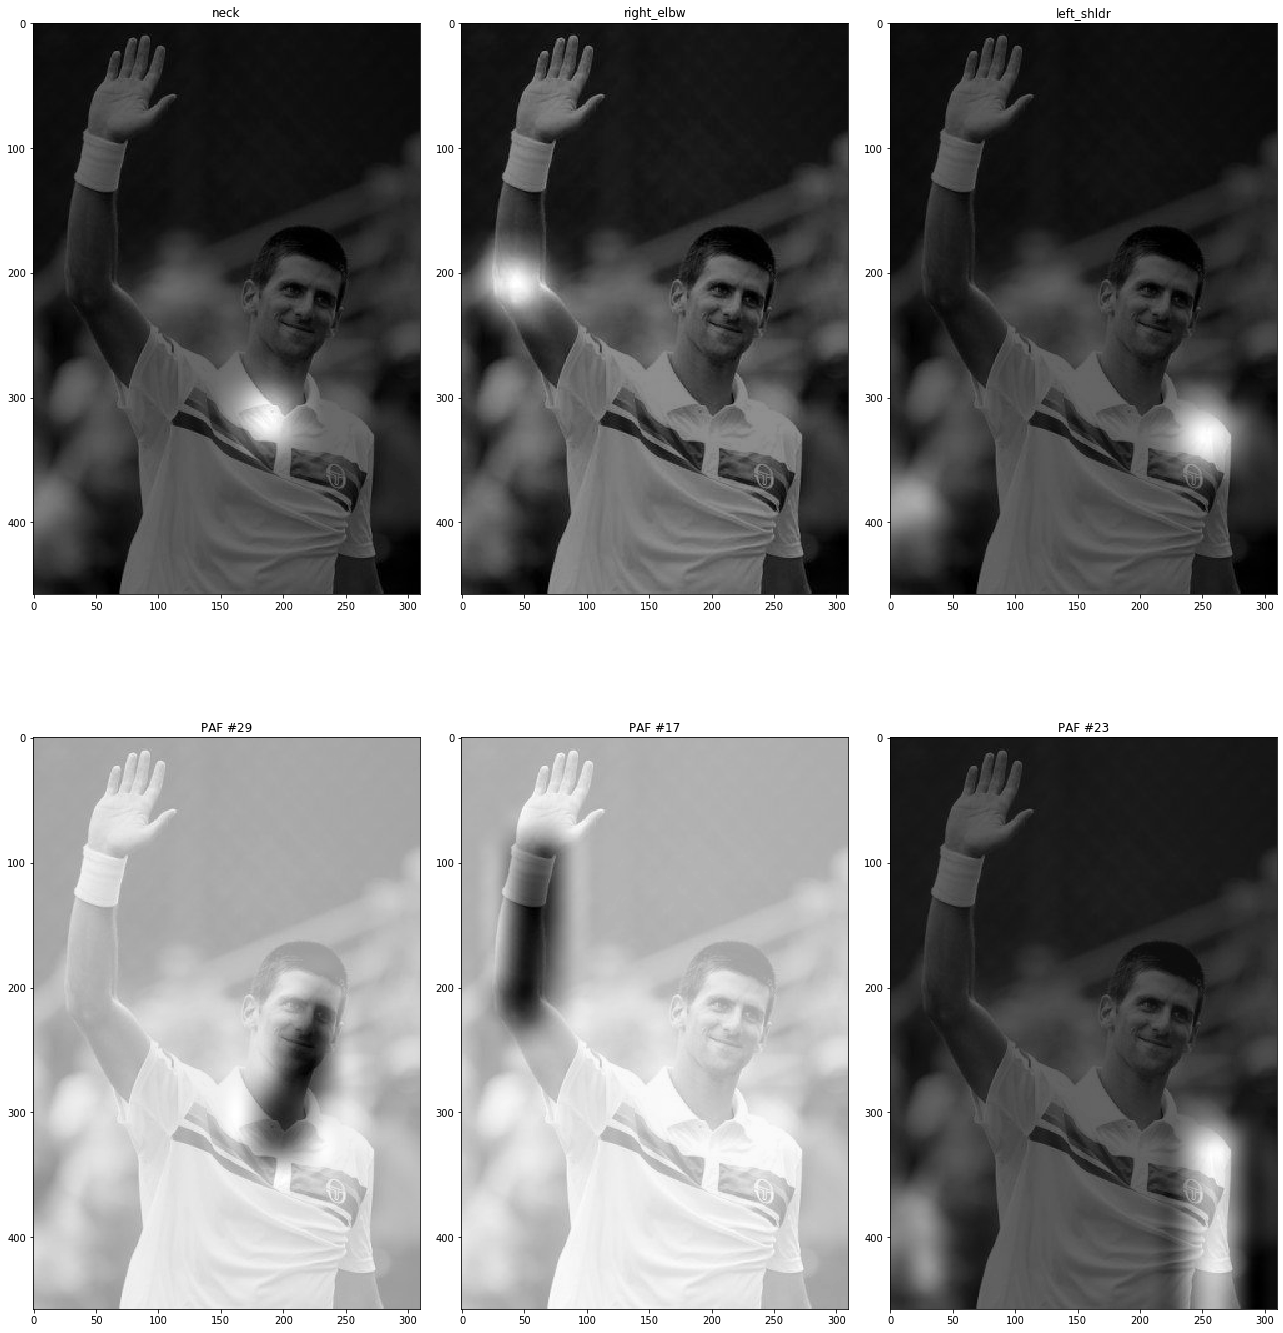

In [30]:
import math

import cv2


test_image = 'images/demo.jpg'


def overlay(img, heatmap, *idxs):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    res = gray / 2
    for idx in idxs:
        res += heatmap[:, :, idx]*220
    return res


def estimate_plot(filename, parts_pairs):
#     objtohighlight = parts["neck"]
    oriImg = cv2.imread(filename)  # B,G,R order
    candidate, subset, heatmap_avg, paf_avg = body_estimation(oriImg)
#     canvas = copy.deepcopy(oriImg)
#     canvas = util.draw_bodypose(canvas, candidate, subset)
#     plt.figure(figsize=(10, 10))
#     plt.imshow(canvas[:, :, [2, 1, 0]])

    parts, pairs = parts_pairs
    
    num_imgs = len(parts) + len(pairs)
    nrows = math.ceil(num_imgs / 3)
    fig, axes = plt.subplots(nrows=nrows, ncols=3)
    fig.set_figwidth(18)
    fig.set_figheight(nrows * 10)
    fig.tight_layout()
    ax = np.asarray(axes).ravel()
    for i, part in enumerate(parts):
        ax[i].imshow(overlay(oriImg, heatmap_avg, PARTS[part]), cmap='gray')
        ax[i].set_title(part)
    for i, pair in enumerate(pairs, start=len(parts)):
        ax[i].imshow(overlay(oriImg, paf_avg, pair), cmap='gray')
        ax[i].set_title(f'PAF #{pair}')


estimate_plot(test_image, (('neck', 'right_elbw', 'left_shldr'), (29, 17, 23)))


In [68]:
#TODO

## 11.2 Investigate on wrong detection

Now that you have your brand new tools we have six images in a folder "images/weirdos_filtered" this images suffer of wrong classifications for obvious reasons. Try for each one to say at which point in the algorythm the things get wrongs based on your heatmaps. If you have ideas of tools to investigate do not hesitate, we would take it in account ;)

(675, 1200, 3)
(398, 615, 3)
(550, 550, 3)
(309, 419, 3)
(1036, 962, 3)
(480, 853, 3)


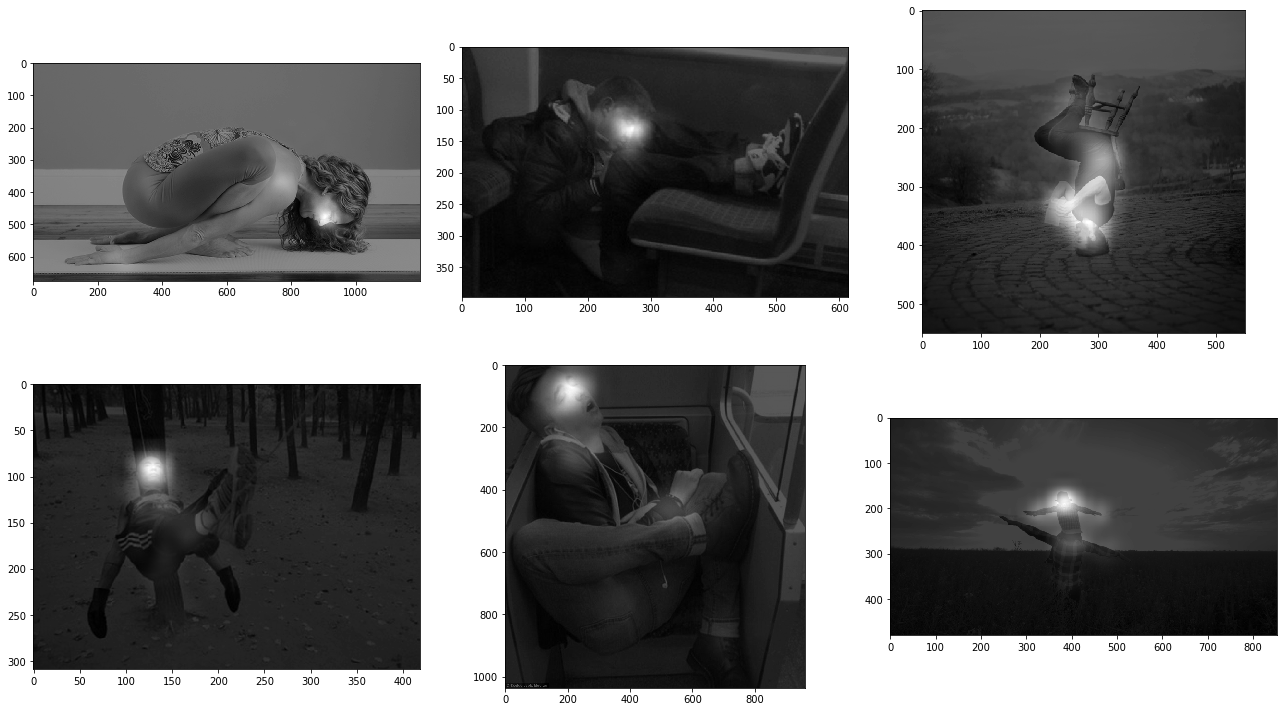

In [35]:
import os

# print(cv2.imshow_collection)

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figwidth(18)
fig.set_figheight(10)
fig.tight_layout()
ax = np.asarray(axes).ravel()

d = 'images/weirdos_filtered'
for i, weirdo in enumerate(os.listdir(d)):
    img = cv2.imread(os.path.join(d, weirdo))
    img_rgb = img[:,:,[2, 1, 0]]
    print(img.shape)
    candidate, subset, heatmap_avg, paf_avg = body_estimation(img)
    ax[i].imshow(overlay(img, heatmap_avg, *range(0, 19)), cmap='gray')
    

Above all joints where highlighted (accumulatively).
On all images the facial "limbs" are visible the best and also spatially related as usual (i.e. there is not split head :D).
Therefore lots of joints are highlighted in the facial area.
Due to the unusual poses in the images the trained model is not able to compute meaningful/"correct" PAFs/PCMs.
This leads to incorrect unit vectors of the limbs and therefore PAFs that contain vectors pointing in "random" (worst case) directions. This in turn reduces the accuracy of the PCM. Since all limbs are connected in a defined way the uncertain joints (actual/human limbs) are positioned around the certain joints (face) (because the PAF "does not lead anywhere else than the certain ones").

So depending on how unusual the pose is, there is variance in how good the pose is being guessed.
Images 2 and 5 (train?) are the worst because the poses are pretty much inhuman (image 4 is almost as bad).

Therefore, one method for improving results would be adding those kind of images to the training data set, but that could also result in less accurate pose guesses for more likely/more human poses.

Using multiple images and the 3D open-pose module would certainly also increase the accuracy majorly, but would also require multiple images for each of the poses.

We are not sure but if one could detect additional data of the pose without using a 3D image, for example the direction of the nose, it could be possible to use that meta data and some knowledge on anatomy to reduce the number of possible positions of joints (resulting in better accuracy). But that would be an extension of the entire open-pose algorithm... ^^